In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import plotly
import os
from sklearn.gaussian_process import GaussianProcessRegressor

## Dummy Function for Testing

In [2]:
noise_level = 0.1
np.random.seed(42)

def function1(x1,x2, noise_level=noise_level):
    result = np.sin(5 * x1+4*x2) * (1 - np.tanh(x1 ** 2) - np.tanh(x2))\
           + np.random.randn() * noise_level
    return result

In [3]:
def generate_initial_data(n):
    train_X = torch.rand(n,2)
    train_Y = [function1(train_X[i,0],train_X[i,1]) for i in range(len(train_X))]
    train_Y = torch.tensor(train_Y).reshape(n,-1)
    max_Y = np.max(train_Y.numpy())
    return train_X, train_Y, max_Y

In [4]:
init_X, init_Y, best_init_Y = generate_initial_data(10)
bounds = torch.stack([torch.zeros(2), torch.ones(2)])

from botorch.models import SingleTaskGP
from botorch  import fit_gpytorch_model

from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf

gp = SingleTaskGP(init_X, init_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [5]:
def get_next_points_UCB(init_X_UCB, init_Y_UCB, best_init_Y_UCB, bounds, n_points=1):
    gp_UCB = SingleTaskGP(init_X_UCB, init_Y_UCB)
    mll_UCB = ExactMarginalLogLikelihood(gp_UCB.likelihood, gp_UCB)
    fit_gpytorch_mll(mll_UCB)
    
    UCB = UpperConfidenceBound(gp_UCB, beta=0.1)
    candidate_UCB, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=20, raw_samples=100,
)
    return candidate_UCB

def get_next_points_EI(init_X_EI, init_Y_EI, best_init_Y_EI, bounds, n_points=1):
    gp_EI = SingleTaskGP(init_X_EI, init_Y_EI)
    mll_EI = ExactMarginalLogLikelihood(gp_EI.likelihood, gp_EI)
    fit_gpytorch_mll(mll_EI)
    
    expected_improvement = qExpectedImprovement(
    model=gp_EI,
    best_f=best_init_Y_EI)
        
    candidate_EI, acq_value = optimize_acqf(
    expected_improvement, bounds=bounds, q=1, num_restarts=20, raw_samples=100
)
    return candidate_EI

def get_next_points_NEI(init_X_NEI, init_Y_NEI, best_init_Y_NEI, bounds, n_points=1):
    gp_NEI = SingleTaskGP(init_X_NEI, init_Y_NEI)
    mll_NEI = ExactMarginalLogLikelihood(gp_NEI.likelihood, gp_NEI)
    fit_gpytorch_mll(mll_NEI)
    
    Nexpected_improvement = qNoisyExpectedImprovement(
    model=gp_NEI,
    X_baseline=init_X_NEI,
    best_f=best_init_Y_NEI)
        
    candidate_NEI, acq_value = optimize_acqf(
    Nexpected_improvement, bounds=bounds, q=1, num_restarts=20, raw_samples=100
)
    return candidate_NEI


In [6]:
#####Loop
n_runs = 20
i_data = 20

init_X, init_Y, best_init_Y = generate_initial_data(i_data)
bounds = torch.stack([torch.zeros(2), torch.ones(2)])

init_X_EI = init_X
init_Y_EI = init_Y
best_init_Y_EI = best_init_Y
best_running_Y_EI = []

init_X_NEI = init_X
init_Y_NEI = init_Y
best_init_Y_NEI = best_init_Y
best_running_Y_NEI = []

init_X_UCB = init_X
init_Y_UCB = init_Y
best_init_Y_UCB = best_init_Y
best_running_Y_UCB = []

for i in range (n_runs):
    new_candidates = get_next_points_EI(init_X_EI, init_Y_EI, best_init_Y_EI, bounds, n_points=1)
    x1,x2 = new_candidates.numpy()[0][0],new_candidates.numpy()[0][1]
    new_results = function1(x1,x2)
    new_results = torch.tensor(new_results).unsqueeze(-1)
    init_X_EI = torch.cat([init_X_EI, new_candidates])
    init_Y_EI = torch.cat([init_Y_EI, new_results.unsqueeze(-1)])    
    best_init_Y_EI = init_Y_EI.max().item()
    best_running_Y_EI.append(best_init_Y_EI)

    new_candidates = get_next_points_NEI(init_X_NEI, init_Y_NEI, best_init_Y_NEI, bounds, n_points=1)
    x1,x2 = new_candidates.numpy()[0][0],new_candidates.numpy()[0][1]
    new_results = function1(x1,x2)
    new_results = torch.tensor(new_results).unsqueeze(-1)
    init_X_NEI = torch.cat([init_X_NEI, new_candidates])
    init_Y_NEI = torch.cat([init_Y_NEI, new_results.unsqueeze(-1)])    
    best_init_Y_NEI = init_Y_NEI.max().item()
    best_running_Y_NEI.append(best_init_Y_NEI)
    
    new_candidates = get_next_points_UCB(init_X_UCB, init_Y_UCB, best_init_Y_UCB, bounds, n_points=1)
    x1,x2 = new_candidates.numpy()[0][0],new_candidates.numpy()[0][1]
    new_results = function1(x1,x2)
    new_results = torch.tensor(new_results).unsqueeze(-1)
    init_X_UCB = torch.cat([init_X_UCB, new_candidates])
    init_Y_UCB = torch.cat([init_Y_UCB, new_results.unsqueeze(-1)])
    best_init_Y_UCB = init_Y_UCB.max().item()
    best_running_Y_UCB.append(best_init_Y_UCB)

C:\Users\paulg\anaconda4\lib\site-packages\botorch\optim\optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\paulg\anaconda4\lib\site-packages\botorch\optim\optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\paulg\anaconda4\lib\site-packages\botorch\optim\optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a ne

In [7]:
print(f'Best initial Y was = {best_init_Y}') 
print(f'EI function improved to = {best_init_Y_EI}') 
print(f'NEI function improved to = {best_init_Y_NEI}') 
print(f'UCB function improved to = {best_init_Y_UCB}') 

Best initial Y was = 0.8247666358947754
EI function improved to = 0.9279191953294146
NEI function improved to = 1.0643797470307117
UCB function improved to = 1.024502737353515


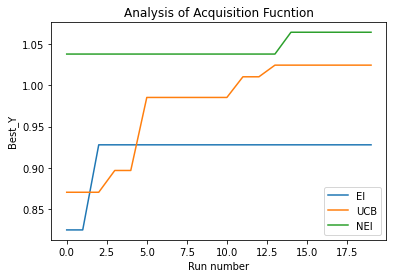

In [8]:
from matplotlib import pyplot as plt

plt.plot(best_running_Y_EI, label = 'EI')
plt.plot(best_running_Y_UCB, label = 'UCB')
plt.plot(best_running_Y_NEI, label = 'NEI')
plt.xlabel('Run number')
plt.ylabel('Best_Y')
plt.title('Analysis of Acquisition Fucntion')
plt.legend()